In [1]:
1+3

ans =  4


# Nonlinear programming and code-generation in CasADi


  Joris Gillis, joris.gillis@kuleuven.be
  
  
  
 - MECO Research Team, Department Mechanical Engineering, KU Leuven
 - DMMS lab, Flanders Make, Leuven, Belgium
 
Benelux-meeting 2019

<div>
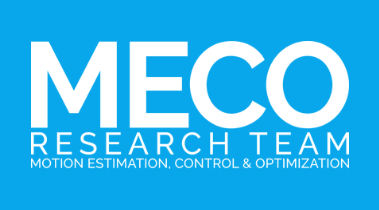

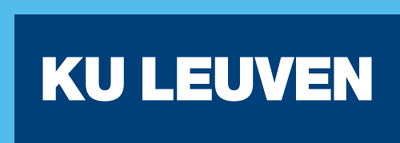
</div>

## Presentation contents

 * Goal
 * Why?
 * How?
 * Help? (What if my NLP does not solve?)


## Goal: from paper to computer
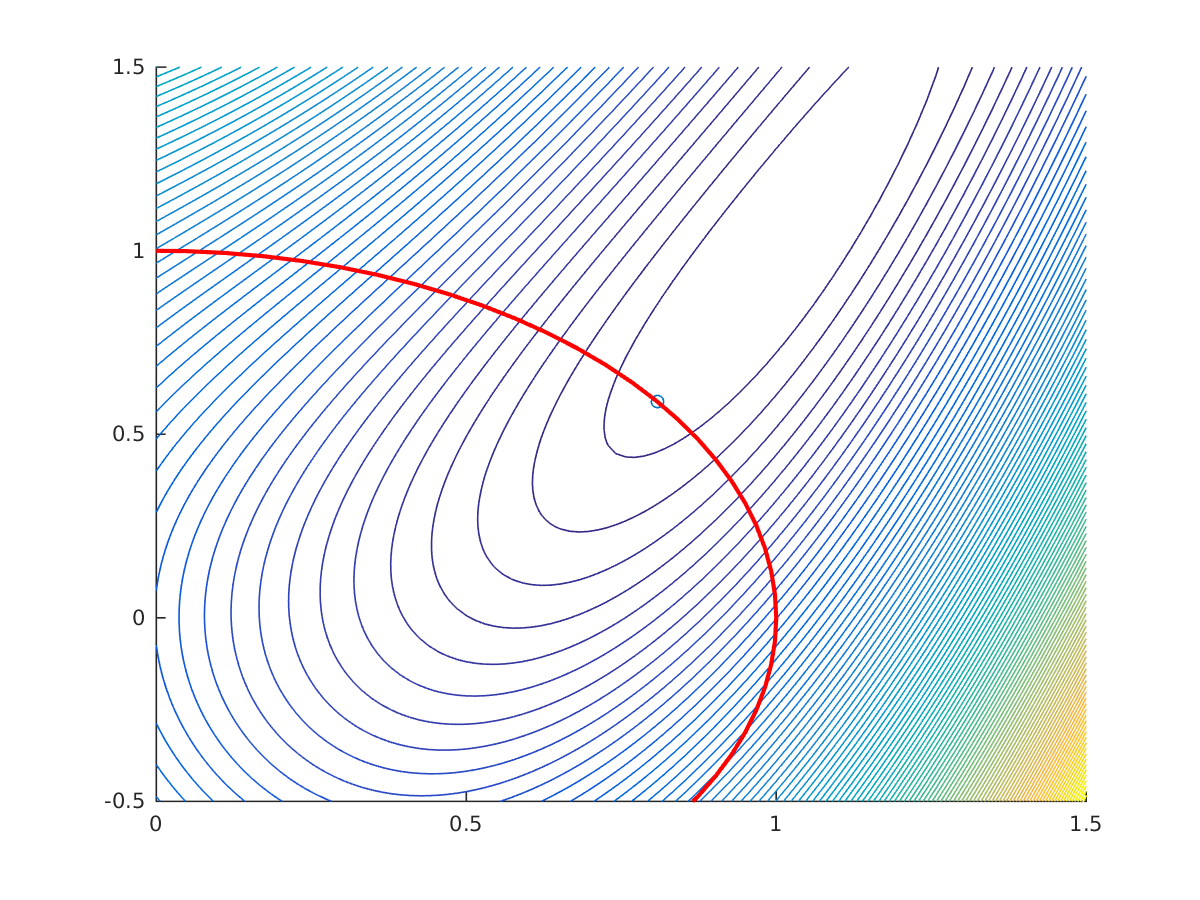

\begin{align}
  \displaystyle \underset{x,y}
  {\text{minimize}}\quad &\displaystyle (1-x)^2+(y-x^2)^2 \\
    \text{subject to} \, \quad & x^2+y^2=1 \\
\end{align}



In [10]:
import casadi.*

T = 10; % Time horizon
N = 20; % Number of control intervals

tgrid = linspace(0,T,N+1);
% States (symbolic)
x1 = MX.sym('x1');
x2 = MX.sym('x2');
x = [x1; x2];
% Controls (symbolic)
u = MX.sym('u');

% Van der Pol oscillator system:
%  nonlinear ODE
dae = struct;
dae.ode = [(1-x2^2)*x1 - x2 + u; x1];
dae.x = x;
dae.p = u;

In [14]:
% Integrator to discretize the system
intg_options = struct;
intg_options.tf = T/N;
intg_options.simplify = true;
intg_options.number_of_finite_elements = 4;
intg = integrator('intg','rk',dae,intg_options)

intg =

intg:(x0[2],p,z0[0],rx0[],rp[],rz0[])->(xf[2],qf[0],zf[2x3],rxf[],rqf[],rzf[]) MXFunction



In [32]:
intg('x0',[0;1],'p',0)

ans =

  scalar structure containing the fields:

    qf =

    []

    rqf =

    []

    rxf =

    []

    rzf =

    []

    xf =

    [-0.494017, 0.876098]

    zf =

    
[[-0.432275, -0.432493, -0.493872], 
 [0.90696, 0.903132, 0.876087]]




In [33]:
x_next = getfield(intg('x0',x,'p',u),'xf')

x_next =

@1=0x0, intg(vertcat(x1, x2), u, 0x1, @1, @1, @1){0}



In [35]:
% Simplify API to (x,u)->(x_next)
F = Function('F',{x,u},{x_next},{'x0','u'},{'xf'})
F([0;1],0)
F([0;1],0.1)

F =

F:(x0[2],u)->(xf[2]) MXFunction

ans =

[-0.494017, 0.876098]

ans =

[-0.443325, 0.88862]



In [37]:
% Simulate numerically

sim = F.mapaccum(N)

x0 = [0;1];
res = sim(x0,zeros(1,N));

sim =

mapaccum_F:(x0[2],u[1x20])->(xf[2x20]) MXFunction



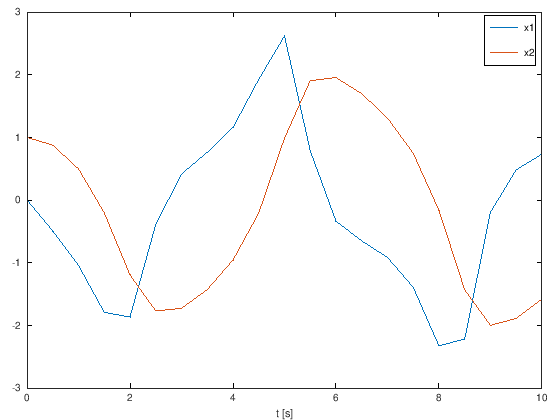

In [38]:
figure
plot(tgrid,full([x0 res]));
legend('x1','x2');
xlabel('t [s]');

res =

mapaccum_F([0, 1], U){0}



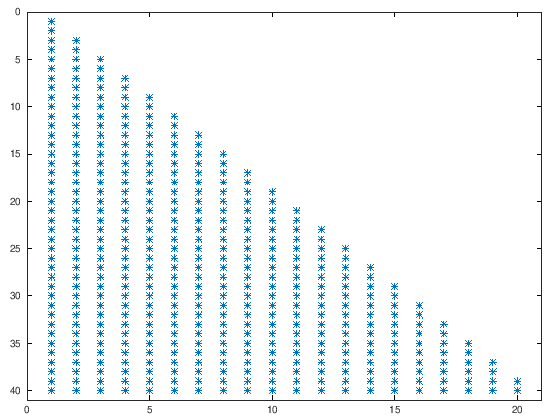

In [40]:
% Simulate symbolically

U = MX.sym('U',1,N);
res = sim(x0,U)
spy(jacobian(res,U))

In [41]:
% Solve an optimal control problem

opti = casadi.Opti();

x = opti.variable(2,N+1);
u = opti.variable(1,N);

opti.minimize(sumsqr(x)+sumsqr(u));

for k=1:N
  opti.subject_to(x(:,k+1)==F(x(:,k),u(:,k)));
end
opti.subject_to(-1<=u<=1);
opti.subject_to(x(1,:)>=-0.25);

p = opti.parameter(2);
opti.subject_to(x(:,1)==p);

opti.solver('sqpmethod',struct('qpsol','qrqp'));

opti.set_value(p,[0;1]);
sol = opti.solve();

-------------------------------------------
This is casadi::QRQP
Number of variables:                              62
Number of constraints:                            83
Number of nonzeros in H:                         182
Number of nonzeros in A:                         203
Number of nonzeros in KKT:                       671
Number of nonzeros in QR(V):                     496
Number of nonzeros in QR(R):                     910
-------------------------------------------
This is casadi::Sqpmethod.
Using exact Hessian
Number of variables:                              62
Number of constraints:                            83
Number of nonzeros in constraint Jacobian:       203
Number of nonzeros in Lagrangian Hessian:        182

iter      objective    inf_pr    inf_du     ||d||  lg(rg) ls
   0   0.000000e+00  1.00e+00  0.00e+00  0.00e+00       -  0
 Iter  Sing        fk      |pr|   con      |du|   var     min_R   con  last_tau  Note
    0     0         0         1   144  2.4e-308     

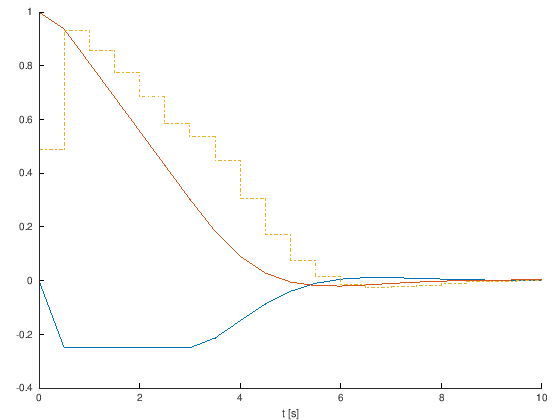

In [43]:
figure
hold on
plot(tgrid,sol.value(x));
stairs(tgrid, [sol.value(u) nan], '-.')
xlabel('t [s]');

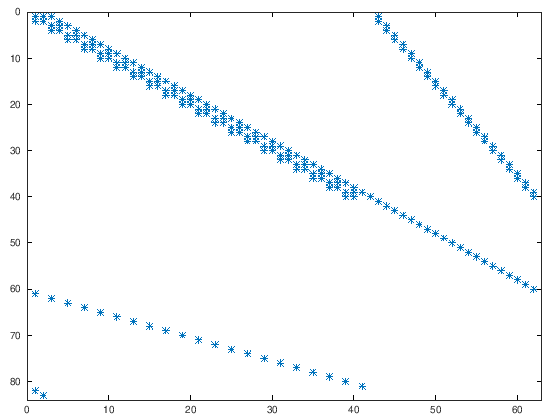

In [45]:
spy(jacobian(opti.g,opti.x));

In [47]:
% Recent advance 1: From Opti (NLP modeling) interface to CasADi Functions
MPC_step = opti.to_function('MPC_step',{p},{u(:,1)});

-------------------------------------------
This is casadi::Sqpmethod.
Using exact Hessian
Number of variables:                              62
Number of constraints:                            83
Number of nonzeros in constraint Jacobian:       203
Number of nonzeros in Lagrangian Hessian:        182

error: casadiMEX: Error in Opti::to_function [OptiNode] at .../casadi/core/optistack.cpp:333:
.../casadi/core/function_internal.hpp:1198: Input 7 (lam_g0) has mismatching shape. Got 2-by-1. Allowed dimensions, in general, are:
 - The input dimension N-by-M (here 83-by-1)
 - A scalar, i.e. 1-by-1
 - M-by-N if N=1 or M=1 (i.e. a transposed vector)
 - N-by-M1 if K*M1=M for some K (argument repeated horizontally)
 - N-by-P*M, indicating evaluation with multiple arguments (P must be a multiple of 1 for consistency with previous inputs)
error: called from
    to_function at line 470 column 28


In [ ]:
X_log = [];
U_log = [];

x = x0;
for i=1:10*N
  u = full(MPC_step(x));

  U_log(:,i) = u;
  X_log(:,i) = x;

  % simulate system
  x = full(F(x,u));
end

tgrid_mpc = linspace(0,10*T,10*N+1);

figure
hold on
plot(tgrid_mpc,X_log);
stairs(tgrid_mpc, [U_log nan], '-.')
xlabel('t [s]');

% Recent advance 2: Loading and saving to disk
MPC_step.save('MPC_step.casadi');

MPC_step2 = Function.load('MPC_step.casadi');

MPC_step(x0)
MPC_step2(x0)

% Recent advance 3: Code-generation with solver embedded

MPC_step.generate('codegen_demo',struct('mex',true));
mex codegen_demo.c -largeArrayDims

codegen_demo('MPC_step',x0)



In [21]:
opti = casadi.Opti();

x = opti.variable();
y = opti.variable();

opti.minimize((1-x)^2+(y-x^2)^2);
opti.subject_to(x^2+y^2==1);

opti.solver('ipopt');
sol = opti.solve();

sol.value([x y])

This is Ipopt version 3.12, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        2
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.

## Presentation contents

 * Goal
 * **Why?**
 * How?
 * Help? (What if my NLP does not solve?)

## Why a modeling language? 

You don't want to lose time with ...
 * ... writing interfaces to solvers
 * ... deriving (debugging) a gradient by hand
 * ... book-keeping of variables
 
```cpp
class MyNLP : public TNLP {
  bool eval_jac_g(const Number* x, ..., Index* iRow, Index *jCol, Number* values) override {
    if (values == NULL) {
      iRow[0] = 1; jCol[0] = 1;
      iRow[1] = 1; jCol[1] = 2;
    } else {
      values[0] = -2.0 * x[0];
      values[1] = -1.0;
    }
  }
}
 ```

## Why CasADi?


What is CasADi?
 * Open-source framework for algorithmic differentiation and nonlinear programming
 * Joel Andersson, Joris Gillis, Greg Horn. Since 2010
 * Feels like both a _scripting language_ and _computer algebra system_
 * http://install.casadi.org
 
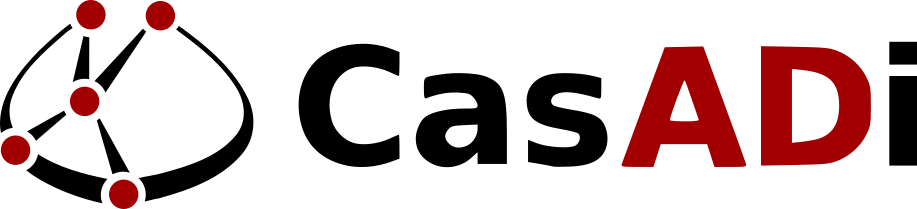

## Why CasADi?

 * C++ core; Python, Matlab, Octave interfaces
 * C code generation
 * Comes with solver interfaces
 * Scales well (matrix-valued expression graphs)
 * Algorithmic differentiation (AD) performs better than symbolic differentiation
 
Illustration: gradient construction time versus horizon length (single-shooting optimal control problem)
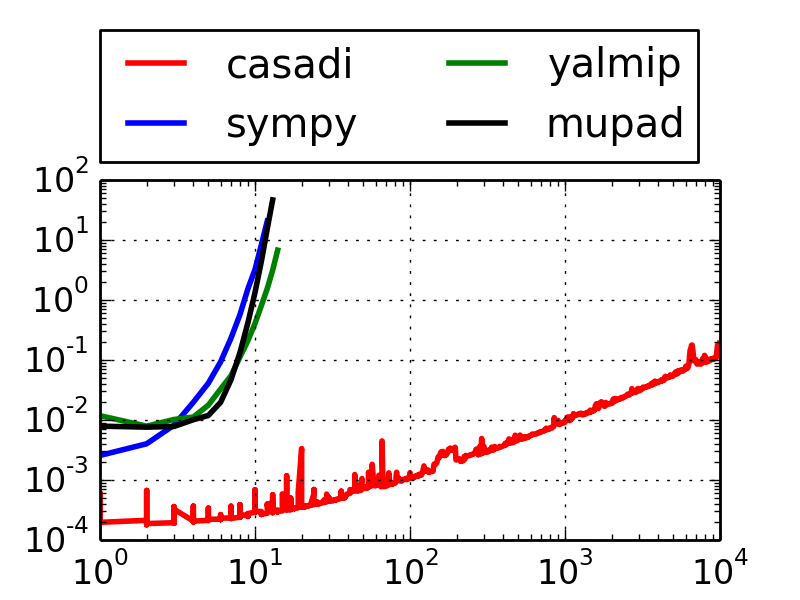


## Presentation contents

 * Goal
 * Why?
 * **How?**
 * Help? (What if my NLP does not solve?)

## How?

Creating symbols for decision variables

In [22]:
opti = casadi.Opti()

x_mat  = opti.variable(4,5);
x_vec  = opti.variable(6);
x_scal = opti.variable();


opti = 

Opti {
  instance #6
  #variables: 0 (nx = 0)
  #parameters: 0 (np = 0)
  #constraints: 0 (ng = 0)
  CasADi solver needs updating.
}


## How?

Composing expressions from symbols

In [23]:
x_scal
expr = cos(0.1*x_scal)


x_scal = 

opti6_x_3

expr = 

cos((0.1*opti6_x_3))


In [25]:
hessian(expr,x_scal)


ans = 

@1=0.1, (-(@1*(0.1*cos((@1*opti6_x_3)))))


## How?

Specify an expression to minimize

In [27]:
opti = casadi.Opti();

N = 25;

x = opti.variable(N);
y = opti.variable(N);

opti.minimize(sum(10*y));

opti


opti = 

Opti {
  instance #8
  #variables: 1 (nx = 25)
  #parameters: 0 (np = 0)
  #constraints: 0 (ng = 0)
  CasADi solver needs updating.
}


## How?

Add constraints

In [28]:
L = 5/N;

opti.subject_to(diff(x).^2+diff(y).^2==L^2);
opti.subject_to([x(1);y(1)]==[-2;1]);
opti.subject_to([x(end);y(end)]==[2;2]);
opti.subject_to(y>=cos(0.1*x)-0.5);

## How?

Solve

In [29]:
opti.solver('ipopt');
sol = opti.solve();

This is Ipopt version 3.12, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      100
Number of nonzeros in inequality constraint Jacobian.:       50
Number of nonzeros in Lagrangian Hessian.............:       98

Total number of variables............................:       50
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       28
Total number of inequality constraints...............:       25
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       25

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.

 100r 3.0799616e+02 1.85e-01 1.44e+02  -1.0 2.21e+01    -  7.96e-03 4.80e-03f  1
 101r 3.0855946e+02 1.84e-01 3.24e+02  -1.0 1.47e+00    -  3.50e-01 2.81e-03f  1
 102r 3.2948979e+02 1.22e-01 5.04e+02  -1.0 1.10e+00    -  5.16e-01 1.46e-01f  1
 103r 3.4533230e+02 8.57e-02 6.26e+02  -1.0 8.77e-01    -  7.43e-01 1.21e-01f  1
 104r 3.6882243e+02 3.13e-02 5.88e+02  -1.0 6.42e-01    -  9.32e-01 2.52e-01f  1
 105r 3.7188218e+02 2.23e-02 6.39e+02  -1.0 3.35e-01    -  1.00e+00 7.26e-02f  1
 106r 3.7540654e+02 1.03e-02 6.61e+02  -1.0 1.48e-01    -  1.00e+00 2.09e-01f  1
 107r 3.7866268e+02 5.69e-04 3.56e+01  -1.0 4.36e-02    -  1.00e+00 1.00e+00f  1
 108  3.7060644e+02 2.30e-02 1.00e+01  -1.0 2.94e+02    -  7.26e-02 3.06e-04f  5
 109  3.6766482e+02 2.30e-02 1.40e+01  -1.0 8.59e+01    -  1.00e+00 8.75e-04f  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  3.6119839e+02 2.46e-02 1.32e+01  -1.0 2.35e+00    -  1.00e+00 3.03e-02f  6
 111  3.5128269e+02 2.39e-02

## How?

Retrieve solution
 * Compute value of expression at solution 


ans =

  217.5110



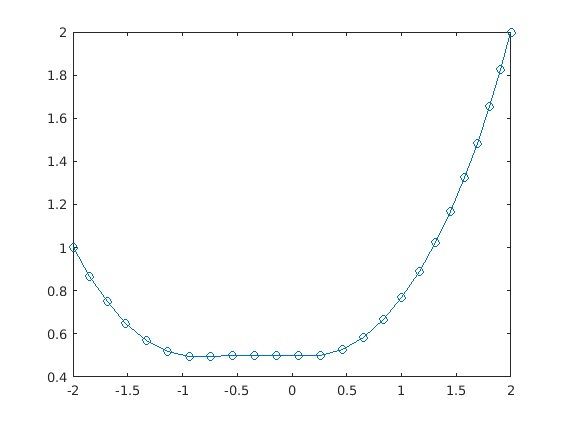

In [32]:
sol.value(opti.f)
plot(sol.value(x),sol.value(y),'-o');

## How?

Inspect standard form

\begin{equation}
  \begin{array}{cl}
    \underset{x}{\textrm{minimize}} & f(x,p) \\
    \textrm{subject to} &  \underline{g}(p) \leq g(x,p) \leq \overline{g}(p)
  \end{array}
\end{equation}

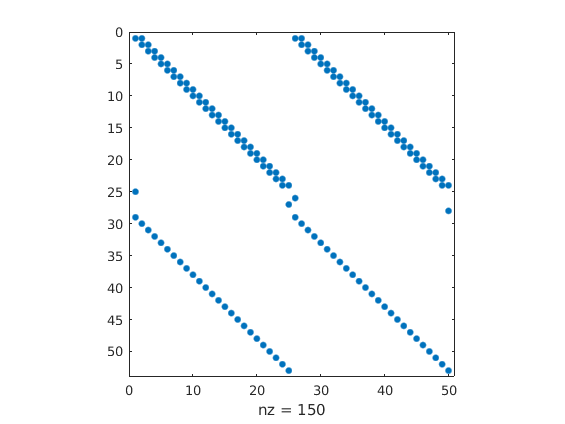

In [37]:
spy(sol.value(jacobian(opti.g,opti.x)))

In [39]:
f=casadi.Function('f',{opti.x,opti.p},{opti.g})
f(rand(50,1),[])


f = 

f:(i0[50],i1[])->(o0[53]) MXFunction

ans = 

[0.186484, 0.0035744, 0.375739, 0.0222814, 0.158713, 0.442474, 0.443907, 0.0612303, 0.265685, 0.676818, 0.468368, 0.0629438, 0.176636, 0.0719071, 0.246709, 0.170286, 0.39433, 0.0618013, 0.0356868, 0.986717, 0.536555, 0.32349, 0.535063, 0.576006, 0.276025, 0.349984, 0.929264, 0.337123, 0.149635, 0.301096, 0.246771, -0.116177, 0.0266403, 0.147099, -0.335431, -0.0858433, -0.0514358, -0.417444, 0.21134, -0.257526, -0.255009, 0.117112, -0.0717876, 0.419548, 0.444553, -0.0308936, -0.279279, -0.434342, 0.366562, -0.0691469, 0.0272959, 0.487801, 0.158563]


## How?

Supply initial values for decision variables

In [40]:
opti = casadi.Opti();
x = opti.variable();

opti.minimize(sin(x)^2);
opti.solver('ipopt',struct('print_time',false),struct('print_level',0));

sol = opti.solve();
sol.value(x)


ans =

     0



In [41]:
opti.set_initial(x, 6);
sol = opti.solve();
sol.value(x)


ans =

    6.2832



## How?

Parametric NLPs

In [42]:
opti = casadi.Opti();
x = opti.variable();
p = opti.parameter();

opti.subject_to(sin(x)==p);
opti.solver('ipopt',struct('print_time',false),struct('print_level',0));

opti.set_value(p, 0.1);
sol = opti.solve();
sol.value(x)

opti.set_value(p, 0.2);
sol = opti.solve();
sol.value(x)


ans =

    0.1002


ans =

    0.2014



## Presentation contents

 * Goal
 * Why?
 * How?
 * **Help?** (What if my NLP does not solve?)

## Help?

NaN/Inf

In [43]:
opti = casadi.Opti();
N = 25;

x = opti.variable(N);
y = opti.variable(N);

opti.minimize(sum(10*y));

opti.subject_to(sqrt(diff(x).^2+diff(y).^2)==L);
opti.subject_to([x(1);y(1)]==[-2;1]);
opti.subject_to([x(end);y(end)]==[2;2]);
opti.solver('ipopt',struct('print_time',false),struct('print_level',0));
sol = opti.solve();

CasADi - 2018-06-20 15:00:06 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 1 (row 1, col 1).") [.../casadi/core/oracle_function.cpp:249]
CasADi - 2018-06-20 15:00:06 WARNING("solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 1 (row 1, col 1).") [.../casadi/core/oracle_function.cpp:249]
Error in Opti::solve [OptiNode] at .../casadi/core/optistack.cpp:159:
.../casadi/core/optistack_internal.cpp:960: Assertion "return_success()" failed:
Solver failed. You may use opti.debug.value to investigate the latest values of variables. return_status is 'Invalid_Number_Detected'


solver:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 1 (row 1, col 1).

In [44]:
opti.debug.g_describe(1)


ans =

Opti constraint of shape 24x1, defined by
  opti.subject_to(sqrt(diff(x).^2+diff(y).^2)==L);
At nonzero 1.



In [45]:
opti.debug.x_describe(1)


ans =

Opti decision variable 'opti11_x_1' of shape 25x1, defined by
  x = opti.variable(N);
At nonzero 1.



## Help?

NaN/Inf in nlp_jac_g: `sqrt(diff(x).^2+diff(y).^2)`

\begin{equation}
\frac{\partial \sqrt{w}}{\partial w} = \frac{1}{2\sqrt{w}}
\end{equation}

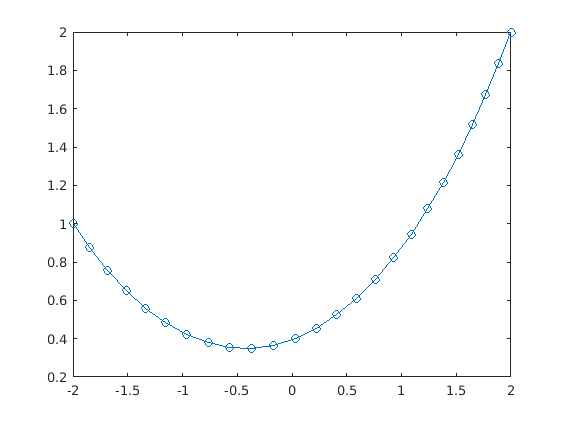

In [46]:
opti.set_initial(x,linspace(1,2,N));
sol = opti.solve();

plot(sol.value(x),sol.value(y),'-o');

## Help?

Infeasible problem

In [48]:
opti = casadi.Opti();

x = opti.variable();
y = opti.variable();

opti.subject_to(-3<=x<= 3);
opti.subject_to(y>=0);
opti.subject_to(sin(x*y)>=2);

opti.solver('ipopt',struct('print_time',false),struct('print_level',0));
sol = opti.solve();

Error in Opti::solve [OptiNode] at .../casadi/core/optistack.cpp:159:
.../casadi/core/optistack_internal.cpp:960: Assertion "return_success()" failed:
Solver failed. You may use opti.debug.value to investigate the latest values of variables. return_status is 'Infeasible_Problem_Detected'


## Help?

Infeasible problem

In [49]:
opti.debug.show_infeasibilities

Violated constraints (tol 0), in order of declaration:
------- i = 3/3 ------ 
2 <= 1 <= inf (viol 1)
Opti constraint of shape 1x1, defined by
  opti.subject_to(sin(x*y)>=2);


## Help?

Variable scaling

In [51]:
opti = casadi.Opti();

N = 100;

x = opti.variable(3,N+1);
y = x(1,:); % height [m]
v = x(2,:); % velocity [m/s]
m = x(3,:); % mass [kg]
u = opti.variable(1,N); % Thrust [N]

opti.subject_to(y(N+1) == 100e3);

opti.set_initial(m,100e3);

f = @(x,u) [x(2);u/x(3)-9.81;-0.00034*u];

dt = 1;
for k = 1:N
    opti.subject_to(x(:,k+1) == x(:,k) + f(x(:,k),u(:,k))*dt);
end

opti.subject_to(m >= 0); % Mass must be positive
opti.subject_to(u >= 0); % Control must remain positive
opti.subject_to(x(:,1) == [0;0;500e3]);

opti.minimize(m(1)-m(N+1)); % minimize fuel consumption

opti.solver('ipopt',struct('print_time',false),struct('print_level',0));
sol = opti.solve();

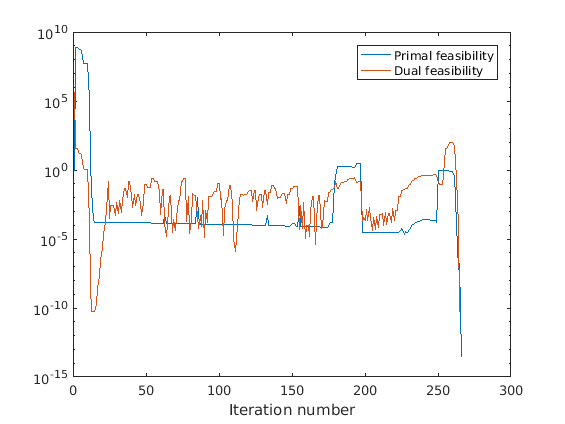

In [52]:
figure
semilogy(sol.stats.iterations.inf_du)
hold on
semilogy(sol.stats.iterations.inf_pr)

xlabel('Iteration number')
legend('Primal feasibility','Dual feasibility')

In [53]:
opti = casadi.Opti();

x = repmat([1e5;2000;300e3],1,N+1).*opti.variable(3,N+1);
y = x(1,:); % height [m]
v = x(2,:); % velocity [m/s]
m = x(3,:); % mass [kg]
u = 1e8*opti.variable(1,N); % Thrust [N]

opti.subject_to(y(N+1) == 100e3);

opti.set_initial(m,100e3);

f = @(x,u) [x(2);u/x(3)-9.81;-0.00033978933*u];

for k = 1:N
    opti.subject_to(x(:,k+1) == x(:,k) + f(x(:,k),u(:,k))*dt);
end


opti.subject_to(m >= 0); % Mass must be positive
opti.subject_to(u >= 0); % Control must remain positive
opti.subject_to(x(:,1) == [0;0;500e3]);

opti.minimize(m(1)-m(N+1)); % minimize fuel consumption

opti.solver('ipopt',struct('print_time',false),struct('print_level',0));
sol = opti.solve();

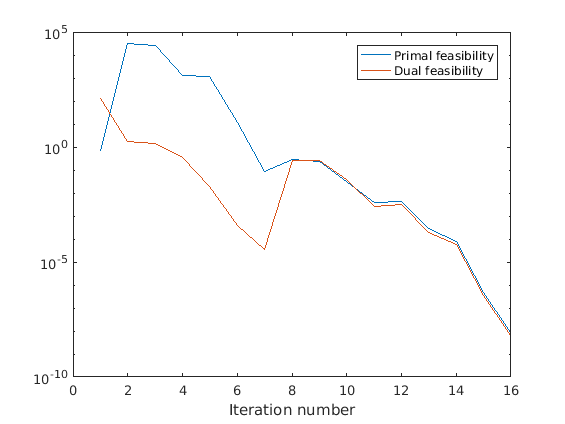

In [54]:
figure
semilogy(sol.stats.iterations.inf_du)
hold on
semilogy(sol.stats.iterations.inf_pr)

xlabel('Iteration number')
legend('Primal feasibility','Dual feasibility')

## Help?

Observing convergence 

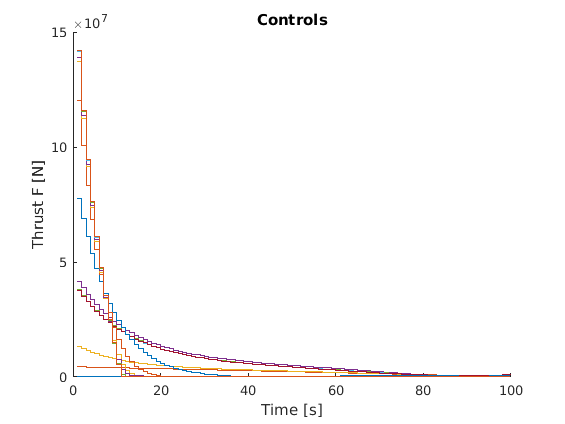

In [55]:
% Post-processing
opti.callback(@(i) stairs(opti.debug.value(u)));

opti.solver('ipopt',struct('print_time',false),struct('print_level',0));

figure
hold on
sol = opti.solve();

xlabel('Time [s]')
ylabel('Thrust F [N]')
title('Controls')

## Take-home message

 * CasADi is an open tool for solving large NLPs (in particular optimal control problems) efficiently
 * The Opti stack makes modeling and debugging easier
 * Succesful for teaching optimization

# Effortless NLP modeling with CasADi's Opti stack


  Joris Gillis, joris.gillis@kuleuven.be
  
  
  
 - MECO Research Team, Department Mechanical Engineering, KU Leuven
 - DMMS lab, Flanders Make, Leuven, Belgium
 

Benelux-meeting 2018